# Goals

Given a small loan-application dataset
1. Gain an understanding of the data
2. Provide analysis of the relationships between the target and the various features
3. Provide analysis of the relationships between important features
4. Build a quick classifier to determine results for new customers
5. Explain the results and reasons why the model is valid

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from pandas_ml import ConfusionMatrix
from collections import defaultdict
import seaborn as sns
%matplotlib inline

## Data Cleaning, Transformation and Exploration

Convert the data set into dataframes and sort by Customer ID

In [2]:
names_credit = ['CustomerID', 'CheckingAccountBalance', 'DebtsPaid', 'SavingsAccountBalance', 'CurrentOpenLoanApplications']
df_credit = pd.read_table('ds-credit.tsv', header=None, sep='\s+', names=names_credit, engine='python')
df_credit_sorted = df_credit.sort_values('CustomerID')

names_results = ['CustomerID', 'WasTheLoanApproved']
df_results = pd.read_table('ds-result.tsv', header=None, sep='\s+', names=names_results, engine='python')
df_results_sorted = df_results.sort_values('CustomerID')

names_app = ['CustomerID', 'LoanPayoffPeriodInMonths', 'LoanReason', 'RequestedAmount', 'InterestRate', 'Co-Applicant']
df_app = pd.read_table('ds-app.tsv', header=None, sep = '\s+', names=names_app, engine='python')
df_app_sorted = df_app.sort_values('CustomerID')

ds-borrow.tsv has an additional header repeated twice in the raw data. We replace the 1st header with our chosen column names and drop the 2nd repeat of header row in the raw data

In [3]:
names_borrow = ['CustomerID', 'YearsAtCurrentEmployer', 'YearsInCurrentResidence', 'Age', 'RentOrOwnHome', 
                'TypeOfCurrentEmployment', 'NumberOfDependantsIncludingSelf']
df_borrow = pd.read_table('ds-borrower.tsv', sep = '\s+', header=None, names=names_borrow, index_col=False, engine='python')
df_borrowed = df_borrow.drop(df_borrow[df_borrow['CustomerID'] == 'Emp'].index)

In [4]:
int_names = ['CustomerID', 'YearsInCurrentResidence', 'Age', 'NumberOfDependantsIncludingSelf']
df_borrowed[int_names] = df_borrowed[int_names].astype(int)
df_borrow_sorted = df_borrowed.sort_values('CustomerID')

Check for duplicates in the data

In [5]:
print("Any duplicates in ds-credit.tsv: ", any(df_credit_sorted.duplicated()))
print("Any duplicates in ds-app.tsv: ", any(df_app_sorted.duplicated()))
print("Any duplicates in ds-borrowed.tsv: ", any(df_borrow_sorted.duplicated()))
print("Any duplicates in ds-result.tsv: ", any(df_results_sorted.duplicated()))

Any duplicates in ds-credit.tsv:  False
Any duplicates in ds-app.tsv:  False
Any duplicates in ds-borrowed.tsv:  False
Any duplicates in ds-result.tsv:  False


Let's see what the data looks like

In [6]:
print("\nds-credit", df_credit_sorted.head())
print("\nds-app", df_app_sorted.head())
print("\nds-borrowed", df_borrow_sorted.head())
print("\nds-result", df_results_sorted.head())


ds-credit      CustomerID CheckingAccountBalance DebtsPaid SavingsAccountBalance  \
422           1                   debt      paid                medium   
228           2                   none   delayed                  none   
608           3                   high   delayed                  high   
165           4                   none      paid                  high   
250           5                   none   delayed                  some   

     CurrentOpenLoanApplications  
422                            1  
228                            2  
608                            3  
165                            1  
250                            2  

ds-app      CustomerID  LoanPayoffPeriodInMonths LoanReason  RequestedAmount  \
392           2                         9      goods             3074   
199           3                        12       auto              939   
663           4                         9       auto             2507   
454           5                   

We find missing data for multiple CustomerIDs across datasets (e.g. ds-app.tsv only starts with CustomerID 2 in table above). To ensure the missing/partial data doesn't influence the training of the model, let's filter by CustomerIDs for which we have a complete loan application profile. Using the CustomerID as the key, we can merge our individual datasets using an inner join to get the intersection of the keys (i.e. CustomerIDs not found in each file are filtered).

In [7]:
df3 = pd.merge(df_app_sorted, df_borrow_sorted, on='CustomerID')
df4 = pd.merge(df_credit_sorted, df_results, on='CustomerID')

df_all = pd.merge(df3, df4, on='CustomerID')
df_all_sorted = df_all.sort_values('CustomerID')

We also see 'Years at Current Employer' Column in ds-borrowed can be simplified by replacing values with 10+ as 10 years

In [8]:
df_all_sorted['YrsatEmp'] = df_all_sorted['YearsAtCurrentEmployer'].replace(['10+', 10])
df_all_sorted['YrsatEmp'] = df_all_sorted['YrsatEmp'].astype(int)

Check all data looks OK and is in the correct data type format

In [9]:
print("Data: \n", df_all_sorted.head())
print(df_all_sorted.info())

Data: 
    CustomerID  LoanPayoffPeriodInMonths LoanReason  RequestedAmount  \
0           2                         9      goods             3074   
1           3                        12       auto              939   
2           4                         9       auto             2507   
3           5                        18      goods             2238   
4           6                        24    repairs             5507   

   InterestRate Co-Applicant YearsAtCurrentEmployer  YearsInCurrentResidence  \
0             1         none                      4                        2   
1             4         none                      7                        2   
2             2         none                    10+                        4   
3             2         none                      4                        1   
4             3         none                    10+                        4   

   Age RentOrOwnHome TypeOfCurrentEmployment  NumberOfDependantsIncludingSelf  \
0  

We're left with 515 entries with complete loan application profiles.

Let's look at some summary statistics about the data and sanity check the number of categories. We'll also get some information on what the typical loan applicant looks like.

In [10]:
nonint_data = ["LoanReason", "Co-Applicant", "RentOrOwnHome", 
               "TypeOfCurrentEmployment", "CheckingAccountBalance", "SavingsAccountBalance","DebtsPaid", "WasTheLoanApproved"]
df_all_sorted[nonint_data].describe()

,LoanReason,Co-Applicant,RentOrOwnHome,TypeOfCurrentEmployment,CheckingAccountBalance,SavingsAccountBalance,DebtsPaid,WasTheLoanApproved
count,515,515,515,515,515,515,515,515
unique,6,3,3,4,4,5,2,3
top,goods,none,owned,skilled,none,some,paid,Y
freq,231,459,366,334,188,306,319,347


Looking at the table above, we see 'Was the Loan Approved' column has 3 categories instead of the expected Y/N. Assuming the agent meant 1 is Y (loan approved), the Results column can be transformed to treat this value correctly.

In [11]:
# WasTheLoanApproved has 3 categories instead of the expected Y/N
print("\nCategories in \"WasTheLoanApproved\" Column: ", df_all_sorted["WasTheLoanApproved"].unique())

"""Assuming the agent meant 1 is Yes the loan is approved, 
the Results column below (transformed Y/N to 1/0) will treat this value correctly"""

# Let's change Y/N in results to a 1/0 value 
df_all_sorted['Result']=df_all_sorted['WasTheLoanApproved'].map(lambda x: 0 if x is 'N' else 1)

print("\nNew Categories in \"Result\" Column: ", df_all_sorted["Result"].unique())


Categories in "WasTheLoanApproved" Column:  ['Y' 'N' '1']

New Categories in "Result" Column:  [1 0]


Approx. 33% of the data is with loans rejected, so we know the data-set is not skewed heavily in one direction. 

In [12]:
int_data = ["LoanPayoffPeriodInMonths", "RequestedAmount", "InterestRate", "YrsatEmp", "YearsInCurrentResidence", "Age",
           "NumberOfDependantsIncludingSelf", "CurrentOpenLoanApplications", "Result"]
df_all_sorted[int_data].describe()

,LoanPayoffPeriodInMonths,RequestedAmount,InterestRate,YrsatEmp,YearsInCurrentResidence,Age,NumberOfDependantsIncludingSelf,CurrentOpenLoanApplications,Result
count,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,21.563107,3365.464078,2.998058,3.821359,2.790291,36.019417,1.151456,1.411650,0.675728
std,12.601857,2999.816986,1.128856,2.385741,1.103013,11.218541,0.358842,0.576333,0.468557
min,4.000000,276.000000,1.000000,0.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1368.500000,2.000000,1.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2337.000000,3.000000,4.000000,3.000000,34.000000,1.000000,1.000000,1.000000
75%,26.500000,4158.000000,4.000000,7.000000,4.000000,43.000000,1.000000,2.000000,1.000000
max,60.000000,18424.000000,4.000000,7.000000,4.000000,75.000000,2.000000,4.000000,1.000000


Let's look for some hints as to what kind of customer is more likely to get their loan approved.

In [13]:
df_Y = df_all_sorted.query('Result == 1')
df_Y.describe()

,CustomerID,LoanPayoffPeriodInMonths,RequestedAmount,InterestRate,YearsInCurrentResidence,Age,NumberOfDependantsIncludingSelf,CurrentOpenLoanApplications,YrsatEmp,Result
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.0
mean,380.011494,19.635057,2908.028736,3.005747,2.827586,36.594828,1.155172,1.433908,3.979885,1.0
std,211.122088,11.372480,2357.865692,1.131152,1.083881,11.016868,0.362590,0.581858,2.319482,0.0
min,2.000000,4.000000,276.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000,1.0
25%,198.250000,12.000000,1350.750000,2.000000,2.000000,28.000000,1.000000,1.000000,1.000000,1.0
50%,389.500000,18.000000,2204.500000,3.000000,3.000000,35.000000,1.000000,1.000000,4.000000,1.0
75%,561.250000,24.000000,3540.250000,4.000000,4.000000,43.000000,1.000000,2.000000,7.000000,1.0
max,750.000000,60.000000,15653.000000,4.000000,4.000000,75.000000,2.000000,4.000000,7.000000,1.0


In [14]:
df_Y[nonint_data].describe()

,LoanReason,Co-Applicant,RentOrOwnHome,TypeOfCurrentEmployment,CheckingAccountBalance,SavingsAccountBalance,DebtsPaid,WasTheLoanApproved
count,348,348,348,348,348,348,348,348
unique,6,3,3,4,4,5,2,2
top,goods,none,owned,skilled,none,some,paid,Y
freq,171,310,259,226,163,183,193,347


Now we have some understanding of the profile of a typical customer who gets their loan approved.

The typical loan is for **goods** with a pay off period of around **18-20months**, the requested amount is around **\$2000-\$3000** with a **3%** interest rate. They are applying for the loan **without a co-applicant** and they also have an additional **1.5 open loan applications**. They have been in their **current residence for nearly 3 years** and typically **own their own home**. Their average **age is 36yrs** with **1 dependent** (including self). They've been with their current **employers for 4yrs** in a **skilled** role. Typically they have **no checking account balance**, **some savings account balance** and their **debts are paid**.

For completeness, let's also see the profile of a typical customer who gets their loan application rejected.

In [15]:
df_N = df_all_sorted.query("Result == 0")
df_N.describe()

,CustomerID,LoanPayoffPeriodInMonths,RequestedAmount,InterestRate,YearsInCurrentResidence,Age,NumberOfDependantsIncludingSelf,CurrentOpenLoanApplications,YrsatEmp,Result
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.0
mean,371.005988,25.580838,4318.682635,2.982036,2.712575,34.820359,1.143713,1.365269,3.491018,0.0
std,218.660035,14.047823,3858.740673,1.127280,1.141241,11.569229,0.351853,0.563544,2.493046,0.0
min,3.000000,6.000000,433.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000,0.0
25%,193.500000,13.000000,1376.500000,2.000000,2.000000,26.000000,1.000000,1.000000,1.000000,0.0
50%,362.000000,24.000000,2775.000000,3.000000,3.000000,32.000000,1.000000,1.000000,4.000000,0.0
75%,546.500000,36.000000,6352.000000,4.000000,4.000000,41.500000,1.000000,2.000000,5.500000,0.0
max,748.000000,60.000000,18424.000000,4.000000,4.000000,74.000000,2.000000,4.000000,7.000000,0.0


In [16]:
df_N[nonint_data].describe()

,LoanReason,Co-Applicant,RentOrOwnHome,TypeOfCurrentEmployment,CheckingAccountBalance,SavingsAccountBalance,DebtsPaid,WasTheLoanApproved
count,167,167,167,167,167,167,167,167
unique,6,3,3,4,4,5,2,1
top,auto,none,owned,skilled,debt,some,paid,N
freq,61,149,107,108,74,123,126,167


The typical loan is for **auto** with a pay off period of around **24-25months**, the requested amount is typically higher than approved customers at around **\$2700-\$4300** with a **3%** interest rate. Similar to approved customers, they are also applying for the loan **without a co-applicant** and they also have an additional **1.5 open loan applications**. They have been in their **current residence for nearly 3 years** and typically **own their own home** - again very similar to approved customers. Their average **age is 34yrs** with **1 dependent** (including self). They've been with their current **employers for 3.5yrs** in a **skilled** role. Typically they are in **debt for their checking account balance**, have **some savings account balance** and their **debts are paid**.

Some insights we can takeaway from this is that overall the approved and rejected applicants follow the general trends seen in overall applicant data - with a few key differences which we can check for significance later on.
1. Approved applicants have no balance vs. Rejected applicants in debt in their Checking Account
2. Approved applicants have been with their current employers for longer 
3. Approved applicants request loans for goods
4. Approved applicants typically request a lower loan amount

## Visualizing the Data

In [17]:
#Create some variables for plotting and use LabelEncoder to encode categorical features into 0 to n classes
d = defaultdict(preprocessing.LabelEncoder)
encode_data = ["LoanReason", "Co-Applicant", "RentOrOwnHome", 
               "TypeOfCurrentEmployment", "CheckingAccountBalance", "SavingsAccountBalance"]


df1 = df_all_sorted[encode_data]
fit = df1.apply(lambda x: d[x.name].fit_transform(x))
fit.apply(lambda x: d[x.name].inverse_transform(x))
df1 = df1.apply(lambda x: d[x.name].transform(x))

df1['Result'] = df_all_sorted['Result']
print("Unencoded --> \n")
print(df_all_sorted[encode_data].head(5))
print("\n Transform categorical data to numeric --> \n")
print(df1.head(5))

Unencoded --> 

  LoanReason Co-Applicant RentOrOwnHome TypeOfCurrentEmployment  \
0      goods         none         owned                 skilled   
1       auto         none         owned                 skilled   
2       auto         none          free                 unskill   
3      goods         none         owned                 skilled   
4    repairs         none          free                 skilled   

  CheckingAccountBalance SavingsAccountBalance  
0                   none                  none  
1                   high                  high  
2                   none                  high  
3                   none                  some  
4                   none                  some  

 Transform categorical data to numeric --> 

   LoanReason  Co-Applicant  RentOrOwnHome  TypeOfCurrentEmployment  \
0           2             2              1                        2   
1           0             2              1                        2   
2           0             2 

From the below plots, it is clear that no pair of features are highly correlated (also see correlation plot below). Although several features are clearly related (e.g. RequestAmount vs LoanPeriodInMonths) this is not sufficent to warrant consolidating them into a single feature.

Note, the data on some of the features are not uniformly sampled. For example, the age, requestedAmount, numberOfDependentsIncludingSelf and currentLoanApplications are all skewed towards lower values. This will reduce the efficiency of the resulting models for predicitions of older loan applicants, larger loan amounts etc.

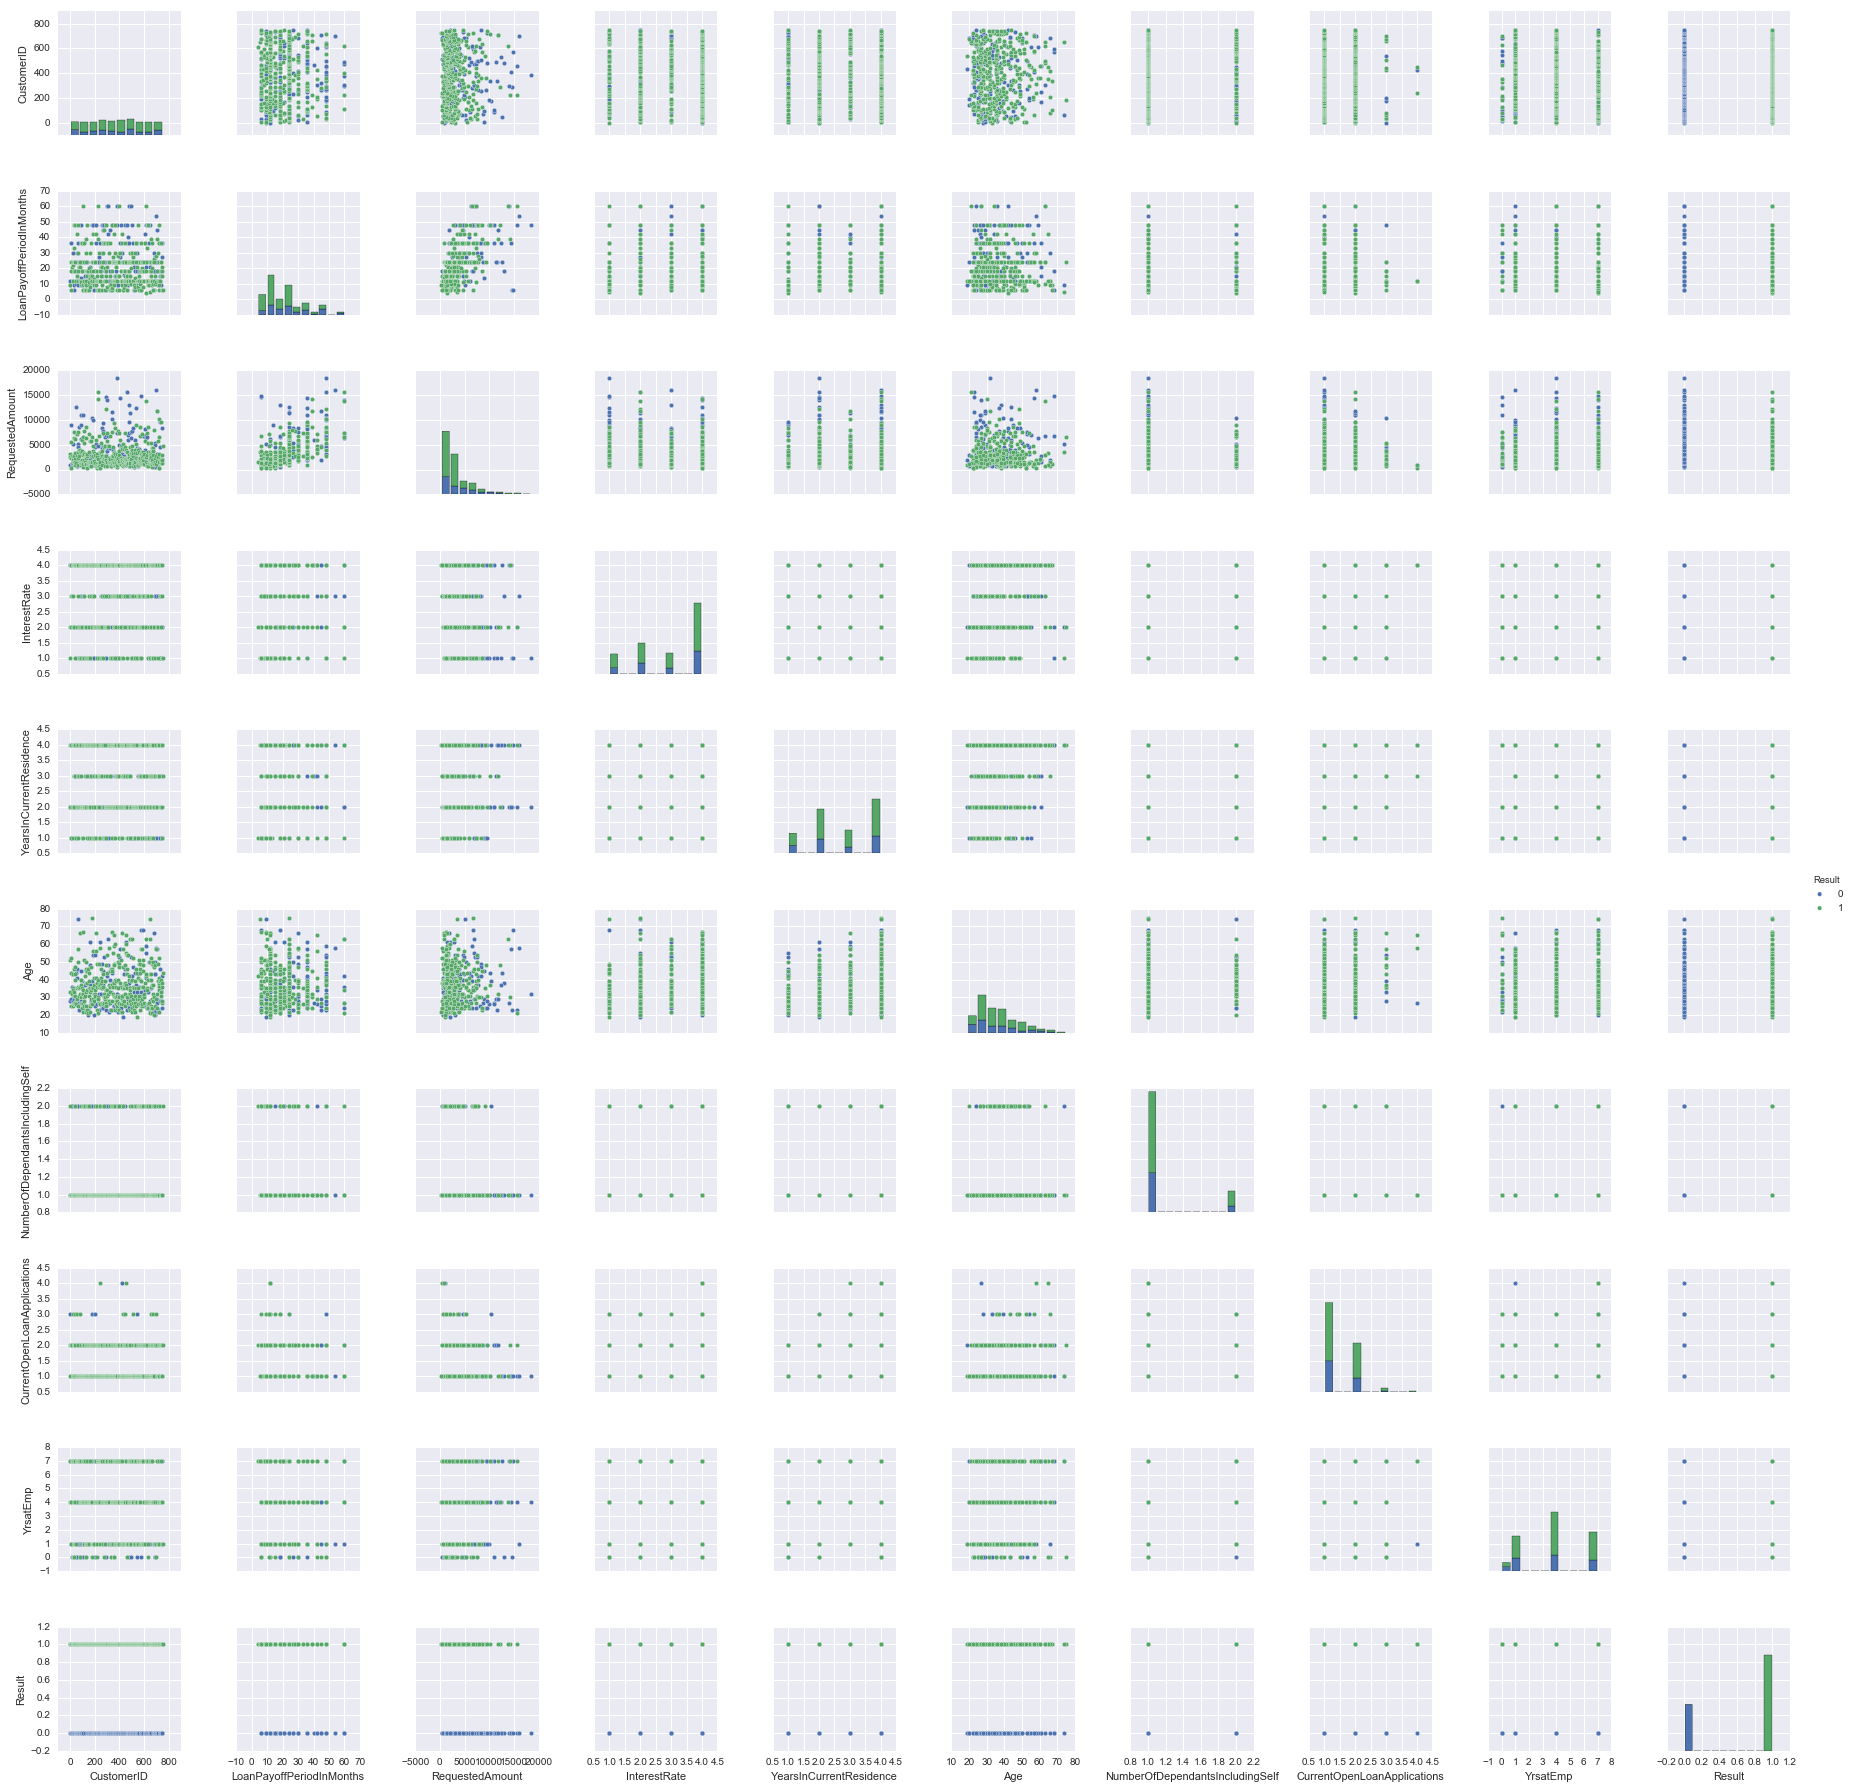

In [18]:
#Plotting scatter plot matrix for numerical type data.

sns.set()
df = df_all_sorted
sns.pairplot(df, hue="Result")


Although the scatter plots for the categorical data are less useful for visualizing relationships, they are sufficent to demostrate that the data has reasonable coverage over all dimensions. In particular, there are few significant data gaps.


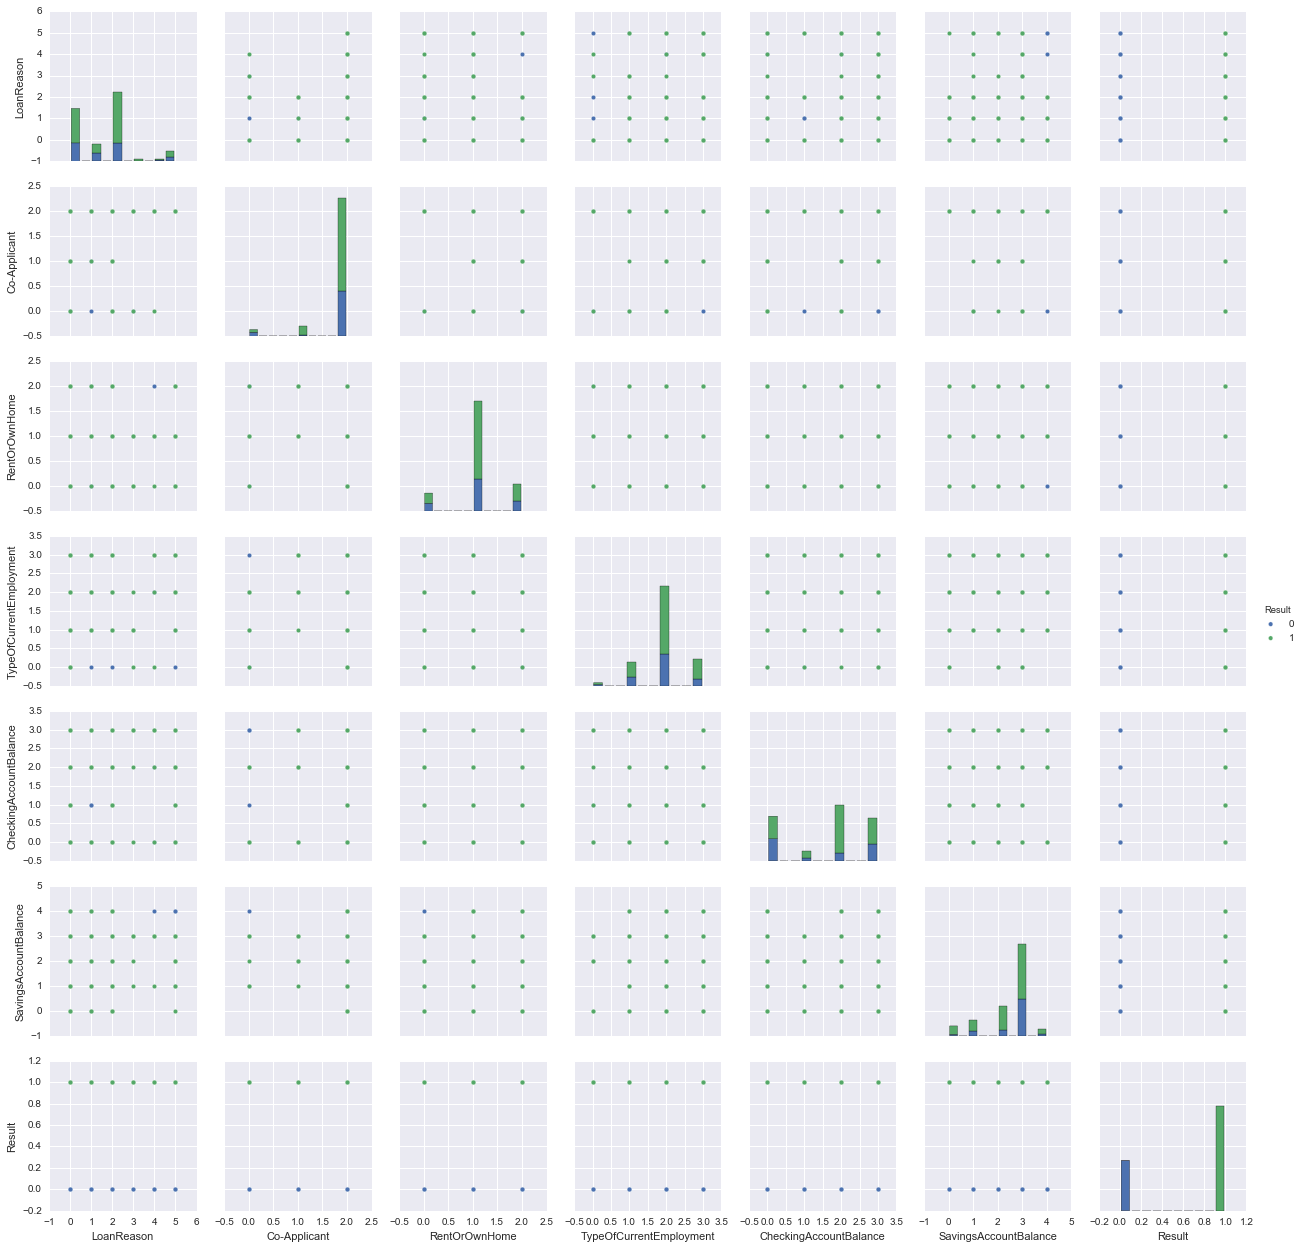

In [19]:
#Plot scatter plot matrix for categorical data

sns.pairplot(df1, hue="Result")

In [20]:
# Convert each categorical variable into a dummy matrix and drop the first dummy to prevent multicollinearity

cols_to_keep = ['CustomerID', 'LoanPayoffPeriodInMonths', 'YrsatEmp', 'RequestedAmount', 'InterestRate', 'YearsInCurrentResidence',
               'Age','NumberOfDependantsIncludingSelf', 'CurrentOpenLoanApplications', 'Result']

dummy_loanreason = pd.get_dummies(df_all_sorted['LoanReason'], prefix='LoanReason', drop_first=True)
dummy_coapp = pd.get_dummies(df_all_sorted['Co-Applicant'], prefix='Co-App', drop_first=True)
dummy_rent = pd.get_dummies(df_all_sorted['RentOrOwnHome'], prefix='RentOwn', drop_first=True)
dummy_typeEmp = pd.get_dummies(df_all_sorted['TypeOfCurrentEmployment'], prefix='Emp', drop_first=True)
dummy_checking = pd.get_dummies(df_all_sorted['CheckingAccountBalance'], prefix='Checking', drop_first=True)
dummy_savings = pd.get_dummies(df_all_sorted['SavingsAccountBalance'], prefix='Savings', drop_first=True)
dummy_debts = pd.get_dummies(df_all_sorted['DebtsPaid'], prefix='Debts', drop_first=True)

data1 = df_all_sorted[cols_to_keep].join(dummy_loanreason.ix[:,:])
data2 = data1.join(dummy_coapp.ix[:,:])
data3 = data2.join(dummy_rent.ix[:,:])
data4 = data3.join(dummy_typeEmp.ix[:,:])
data5 = data4.join(dummy_checking.ix[:,:])
data6 = data5.join(dummy_savings.ix[:,:])
data = data6.join(dummy_debts.ix[:,:])


#Reorder columns
data['Results'] = data['Result']
del data['Result']


From the correlation matrix plot below, we can make the following observations:
* As mentioned above, Requested Amount and Loan Pay Off Period are significantly correlated.
* As expected there is a strong negative correlation between features from the same dummy matrix, since only one feature in each dummy matrix will appear. Thus, for example if a data entry has RentOwn_owned = 1, then it will have RentOwn_rent = 0 and vice-versa. 
* The correlation of each feature with the target Results is examined in more detail below.

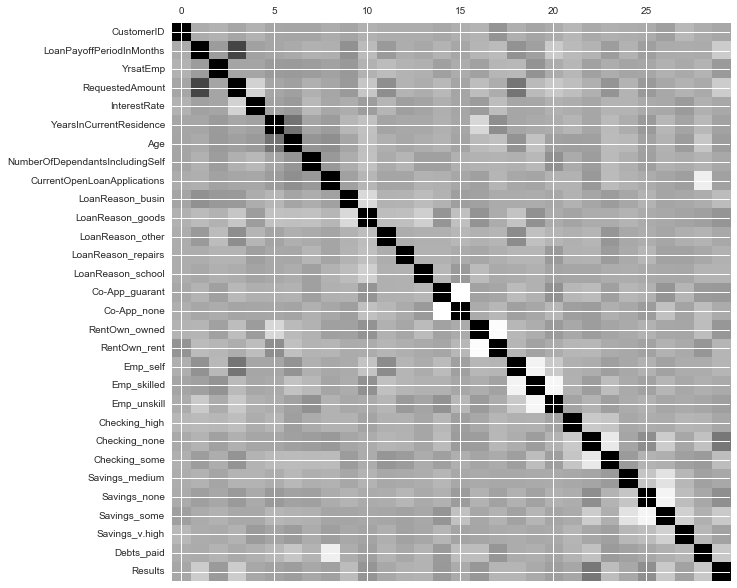

In [21]:
# Plot the correlation matrix to examine correlations between each pair of features and the target Result.
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    #plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
plot_corr(data)

* CustomerID should display no correlation with the decision to approve a loan, and indeed this is the case.
* Features with a significant (although still small) correlation with the decision to approve a loan include:
  * LoanPayoffPeriodInMonth: This negative correlation is as expected, since shorter terms loans are likely to be less risky, and hence easier to approve.
  * RequestedAmount: This negative correlation is as expected, since smaller loans are less risky, and hence easier to approve
  * Checking_none, Savings_some, Debts_paid are the most frequent values in each category as well as being the most frequent values for customers with loans approved - possibly contributing to their higher apparent correlation to the loan decision. Having a low (or none) checking balance is unlikely to indicate a causal relationship with the loan decision, however it seems reasonable that customers with low/none checking balances are more likely to apply for a loan. Note, applicants in debt with their checking account were less likely to get a loan.
 * Of the possible loan reasons, 'goods' has the strongest correlation with the decision to appove a loan, possibly because the purchased goods can act as collatoral for the loans.
* Neither age, nor employement type show a strong correlation with the decision to approve a loan.

In [22]:
# List the numerical values of the correlation matrix
corr_data = data.corr()
print(corr_data['Results'])

CustomerID                         0.019771
LoanPayoffPeriodInMonths          -0.221074
YrsatEmp                           0.096013
RequestedAmount                   -0.220337
InterestRate                       0.009842
YearsInCurrentResidence            0.048857
Age                                0.074113
NumberOfDependantsIncludingSelf    0.014964
CurrentOpenLoanApplications        0.055803
LoanReason_busin                  -0.094374
LoanReason_goods                   0.124331
LoanReason_other                   0.009669
LoanReason_repairs                -0.034238
LoanReason_school                 -0.049693
Co-App_guarant                     0.100652
Co-App_none                       -0.002122
RentOwn_owned                      0.106881
RentOwn_rent                      -0.056391
Emp_self                          -0.057926
Emp_skilled                        0.002666
Emp_unskill                        0.067553
Checking_high                      0.017127
Checking_none                   

## Model Training

In [23]:
# Setting up the training (70%) and test (30%) sets. 
np.random.seed(7)
msk1 = np.random.rand(len(data)) < 0.7
train = data[msk1]
test = data[~msk1]

Start with logistic regression since it is the simplest to interpret

In [24]:
#Exclude CustomerID and Results from feature columns
features = train.columns[1:-1]

# Initialize logistic regression model
log_model = LogisticRegression()

# Train the model
log_model.fit(X = train[features] ,
              y = train['Results'])

# Check trained model intercept
print("Trained model intercept: ", log_model.intercept_)

Trained model intercept:  [ 0.64395622]


Extract the most important features

In [25]:
"""Using Recursive Feature Extraction to rank the most important features in the model"""

rfe = feature_selection.RFE(log_model, 1)
rfe = rfe.fit(train[features], train['Results'])

print ("Features sorted by their rank:")

tmp_lst = list(map(lambda x: round(x, 4), rfe.ranking_))
Feature_coeff = pd.DataFrame({"Feature_Rank":tmp_lst, "Features":features, "Model_Coeff":log_model.coef_[0]})
Feature_coeff_sorted = Feature_coeff.sort_values('Feature_Rank')
print(Feature_coeff_sorted)


Features sorted by their rank:
    Feature_Rank                         Features  Model_Coeff
21             1                    Checking_none     1.613786
13             2                   Co-App_guarant     1.500234
20             3                    Checking_high     0.745901
27             4                       Debts_paid    -0.868045
25             5                     Savings_some    -0.811264
14             6                      Co-App_none     0.618843
9              7                 LoanReason_goods     0.575861
23             8                   Savings_medium    -0.328581
10             9                 LoanReason_other     0.574016
19            10                      Emp_unskill     0.248812
12            11                LoanReason_school    -0.378633
8             12                 LoanReason_busin    -0.303537
26            13                   Savings_v.high    -0.056848
22            14                    Checking_some     0.188815
1             15        

Directly interpreting the regression coefficients can be misleading, hence we should look at the feature importance which tells us how important the feature was for predicting the target. For additional model refinement, we could use these results for better feature selection.

In [26]:
# Make predictions on the training set
preds = log_model.predict(X= train[features])

Train_Results = pd.DataFrame({"CustomerID":train["CustomerID"],
                           "ActualOutcome":train["Results"],
                           "PredictedReceivedLoan":preds})

# Generate table of predictions vs actual
pd.crosstab(preds, train["Results"],rownames=["Predicted"], colnames=["Actual"])


Actual,0,1
Predicted,,
0,59,24
1,57,215


The predictions on the training set show that the model performs reasonably well, we can look at more detailed statistics below.

In [27]:
cm = ConfusionMatrix(Train_Results['ActualOutcome'], Train_Results['PredictedReceivedLoan'])
cm.print_stats()

population: 355
P: 239
N: 116
PositiveTest: 272
NegativeTest: 83
TP: 215
TN: 59
FP: 57
FN: 24
TPR: 0.899581589958
TNR: 0.508620689655
PPV: 0.790441176471
NPV: 0.710843373494
FPR: 0.491379310345
FDR: 0.209558823529
FNR: 0.100418410042
ACC: 0.771830985915
F1_score: 0.841487279843
MCC: 0.452355497403
informedness: 0.408202279613
markedness: 0.501284549965
prevalence: 0.67323943662
LRP: 1.83072744623
LRN: 0.197432806184
DOR: 9.27266081871
FOR: 0.289156626506


* Our training set population consists of 355 customers, 239 with loan approved, 116 with loan rejected.
* Our model was able to predict 274 of the outcomes of loan applications correctly with an accuracy of 0.77. 
* Precision (PPV) is 0.8 and recall (TPR) is 0.9 - both indicating the model performs well on the training set.
* Generally, we would need some business knowledge to determine whether the bank prioritizes reducing False Positives or False Negatives i.e. whether a customer who should not be approved is approved by the model or a customer who should be approved is rejected by the model.
* Follow up model refinement should include reducing the false positive rate.
* Overall, the F1_Score of 0.85 also indicates the model performs well on the training set.

## Model Selection and Validation

Let's take a look at some other model candidates. We use a 10-fold cross validation method to estimate accuracy for each model. This splits the dataset into 10 parts, trains on 9 of them and then tests on 1 repeating the process for all combinations of splits.

The scoring metric is a simple accuracy measure i.e. number of correct predictions/total instances.

We evaluate the following using the same data splits of test/train ensuring the results are comparable -
* Logistic Regression (LR)
* K-Nearest Neighbor (KNN)
* Decision Trees (CART)
* Naive Bayes (NB)
* Support Vector Machines (SVM)
* Random Forest (RF)

In [28]:
# Consider other model options and evaluate metrics using k-folds cross-validation
num_folds = 10
num_instances = len(train[features])
seed = 7
scoring = 'accuracy'
models = []

models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, train[features], train['Results'], cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.729603 (0.089404)
KNN: 0.634127 (0.076998)
CART: 0.648095 (0.078385)
NB: 0.681905 (0.091197)
SVM: 0.673333 (0.086792)
RF: 0.710079 (0.077954)


Comparing Algorithms, we see Logistic regression has the highest mean accuracy but also a large standard deviation. An alternate model to explore in the future would be random forest since it has a comparable accuracy but also a smaller standard deviation.

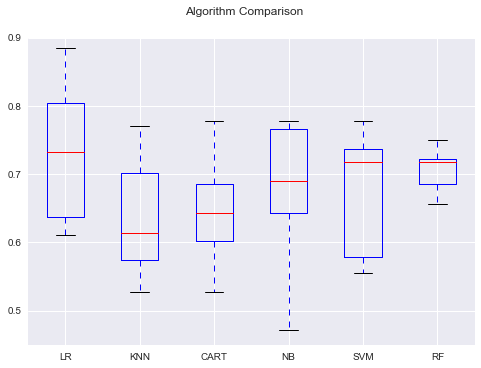

In [29]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Model Evaluation

We're picking logistic regression because it has the highest accuracy for this data set. 

Now let's make predictions on our hold-out test set using this trained model.

In [30]:
# Model predictions on test set
test_preds = log_model.predict(X=test[features])

Test_Results = pd.DataFrame({"CustomerID":test["CustomerID"],
                           "ActualOutcome":test["Results"],
                           "PredictedReceivedLoan":test_preds})


pd.crosstab(test_preds, test["Results"],rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,21,11
1,30,98


In [31]:
cm = ConfusionMatrix(Test_Results['ActualOutcome'], Test_Results['PredictedReceivedLoan'])
cm.print_stats()

population: 160
P: 109
N: 51
PositiveTest: 128
NegativeTest: 32
TP: 98
TN: 21
FP: 30
FN: 11
TPR: 0.899082568807
TNR: 0.411764705882
PPV: 0.765625
NPV: 0.65625
FPR: 0.588235294118
FDR: 0.234375
FNR: 0.100917431193
ACC: 0.74375
F1_score: 0.827004219409
MCC: 0.362130769212
informedness: 0.31084727469
markedness: 0.421875
prevalence: 0.68125
LRP: 1.52844036697
LRN: 0.245085190039
DOR: 6.23636363636
FOR: 0.34375


The model results on our final test set are promising. 

Reasons why the model is valid:
* Our test set population consists of 160 customers, 109 with loan approved, 51 with loan rejected.
* Our model was able to predict 119 of the outcomes of loan applications correctly with an accuracy of 0.74.
* Precision (PPV) is 0.76 and recall (TPR) is 0.9 - both comparable to the results from the training set.
* Overall, the F1_Score of 0.82 also indicates the model performs well on the test set.

## Investigating next steps

<module 'matplotlib.pyplot' from 'C:\\Users\\IBM_ADMIN\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

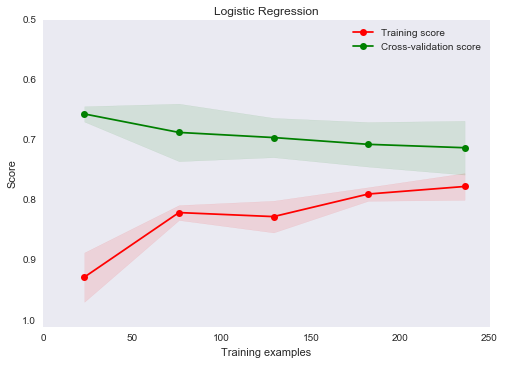

In [32]:
# Plot learning curves using sklearn's default learning curve plotting function

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Logistic Regression"

plot_learning_curve(LogisticRegression(), title, train[features], train['Results'], ylim=(1.01, 0.5))            

The learning curves suggest we could benefit from adding more samples to the training set. This is indicated by the fact that the cross-validation accuracy score is trending downwards i.e. error will continue to decrease by adding more samples. In addition, the training score starts off with very low error on a small subset of training samples and trends upwards with increasing training examples i.e. training error will continue to climb and cross-validation error will continue to decrease with increasing the number of training examples. In addition, since this type of learning curve indicates high-variance, using our feature importance rank can help to down-select the number of features in the model.
Next Steps to improve model performance:
* Increase the training set size
* Carefully considered feature selection based on feature importance

## Summary

* We looked at a small loan-application dataset to see if we can double-check the work of agents making quick-fire loan determinations.

* Created a profile of the average loan applicant, approved customers and rejected customers.

* Determined relationships between target and various features
  * Approved customers typically have no balance in their checking account
  * Rejected customers are usually in debt in their checking account
  * Approved customers have been with their current employers for an average of 4yrs
  * Approved customers request loans for goods whereas rejected customers usually request auto-loans
  * Approved customers typically request lower loan amounts
  
* Determined correlations and relationships between important features
  * Loan pay off period and requested amount show some correlation - this should be expected since smaller amounts can be paid off quicker
  * Shorter loan period and smaller requested amount are likely to be approved
  * Loan decision shows correlation to having no balance in checking account, some balance in savings account and having debts paid
  * Of the possible loan types, loans requested for 'goods' are likely to be approved, possibly because purchased goods can act as collateral for loans.
  
* Trained a quick classifier for new customers
  * Trained a simple logistic regression model
  * Determined feature importance
  * Evaluated alternate models

* Results
  * Selected logistic regression model and validated model accuracy of 0.74 and F1-score of 0.82 with high precision and recall
  
* Suggested next steps
  * Careful feature selection to reduce variance
  * Try random forest model for increased robustness
  * Increase training set as learning curves have not converged yet